## The Movie DataBase (TMDB)

The goal of this project is to extract data from themoviedb.org using an API and perform some Pre-Processing and Exploratory Data Analysis. We have extracted data from the Movie db.
Below is the documentation for the API to get a better understanding.
https://developer.themoviedb.org/reference/intro/getting-started

This project can be used by sociologists, in order to understand the culture of each decade by analyzing the data of the highest earning movie for each decade. It can also be used for a movie reccomendation system.

In [54]:
import csv
import requests
import json


# getting movies based on highest revenue by each year
def fetch_movies(api_key, year, page=1):
    url = f"https://api.themoviedb.org/3/discover/movie?api_key={api_key}&language=en-US&sort_by=revenue.desc&primary_release_year={year}&page={page}"
    
    response = requests.get(url)
    
    if response.status_code == 200:
        return json.loads(response.text)
    else:
        return None

# getting movie details based on fetch_movies
def fetch_movie_details(api_key, movie_id):
    url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key}&language=en-US&append_to_response=keywords,credits"
    
    response = requests.get(url)
    
    if response.status_code == 200:
        return json.loads(response.text)
    else:
        return None

def format_movie_details(movie_details):
    # Extracting genres
    genres = [genre['name'] for genre in movie_details.get('genres', [])]

    # Extracting keywords
    keywords = [keyword['name'] for keyword in movie_details.get('keywords', {}).get('keywords', [])]

    # Extracting director(s)
    credits = movie_details.get('credits', {})
    directors = [crew['name'] for crew in credits.get('crew', []) if crew['job'] == 'Director']

    # Extracting top 5 cast members
    cast = [cast_member['name'] for cast_member in credits.get('cast', [])][:5]

    # Extracting production companies
    companies = [company['name'] for company in movie_details.get('production_companies', [])]

    # Formatting the extracted details into strings
    formatted_genres = ", ".join(genres)
    formatted_keywords = ", ".join(keywords)
    formatted_directors = ", ".join(directors)
    formatted_cast = ", ".join(cast)
    formatted_companies = ", ".join(companies)

    return formatted_genres, formatted_keywords, formatted_directors, formatted_cast, formatted_companies

if __name__ == "__main__":
    api_key = "" # Removed API Key

    # Writing into CSV
    for year in range(1970, 2023):
        filename = f'box_office_hits_{year}.csv'
        with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
            # writing rows into the CSV file
            csv_writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            
            # Defining the Header Row for the CSV file
            csv_writer.writerow(["Release Date", "Title", "Rating", "Budget", "Revenue", "Genres", "Keywords", "Director", "Cast", "Production Companies"])

        
            movies = fetch_movies(api_key, year)
            if movies and 'results' in movies:
                for movie in movies['results'][:20]:
                    movie_details = fetch_movie_details(api_key, movie['id'])
                    
                    if movie_details:
                        formatted_genres, formatted_keywords, formatted_directors, formatted_cast, formatted_companies = format_movie_details(movie_details)
                        csv_writer.writerow([movie_details['release_date'], movie_details['title'], movie_details['vote_average'], movie_details['budget'], movie_details['revenue'], formatted_genres, formatted_keywords, formatted_directors, formatted_cast, formatted_companies])

In the above code cell, we extracted data from each year since 1970 till 2022 and created a CSV file for each year. In the bottom cell, we are merging all of our csv files into one which would later be used for EDA

In [55]:
import pandas as pd
import os

def merge_csv_files(start_year, end_year, output_file):
    # List to hold data from all CSV files
    all_data = []

    for year in range(start_year, end_year + 1):
        filename = f'box_office_hits_{year}.csv'

        # Check if the file exists
        if os.path.exists(filename):
            # Read the CSV file and append to the list
            df = pd.read_csv(filename, encoding='ISO-8859-1')
            all_data.append(df)

    # Concatenate all dataframes into one
    merged_df = pd.concat(all_data, ignore_index=True)

    # Save the merged dataframe to a new CSV file
    merged_df.to_csv(output_file, index=False)

    return f"Merged CSV file created: {output_file}"

# Merge CSV files from 1970 to 2022
merge_csv_files(1970, 2022, 'merged_box_office_hits.csv')

'Merged CSV file created: merged_box_office_hits.csv'

## Data Pre-Processing and Cleaning

We will search for null values and duplicates and clean them if there are any. We will also add a couple of columns based on the existing ones.

In [56]:
df = pd.read_csv('merged_box_office_hits.csv')

df.head()

,Release Date,Title,Rating,Budget,Revenue,Genres,Keywords,Director,Cast,Production Companies
0,1970-12-16,Love Story,6.775,2200000,136400000,"Romance, Drama","based on novel or book, harvard university, co...",Arthur Hiller,"Ali MacGraw, Ryan O'Neal, John Marley, Ray Mil...","Paramount, Love Story Company"
1,1970-05-29,Airport,6.400,10000000,100489151,"Action, Drama, Thriller","airplane, airport, based on novel or book, pan...",George Seaton,"Burt Lancaster, Dana Wynter, Dean Martin, Barb...",Ross Hunter Productions
2,1970-01-25,Patton,7.526,12000000,89800000,"War, Drama, History","general, steel helmet, allies, world war ii, n...",Franklin J. Schaffner,"George C. Scott, Stephen Young, Frank Latimore...",20th Century Fox
3,1970-02-18,M*A*S*H,6.965,3500000,81600000,"Comedy, Drama, War","american football, dark comedy, surgeon, ameri...",Robert Altman,"Donald Sutherland, Elliott Gould, Tom Skerritt...","Aspen Productions (I), Ingo Preminger Producti..."
4,1970-12-24,The Aristocats,7.291,4000000,55675257,"Animation, Comedy, Family, Adventure","paris, france, return, butler, suspension, inh...",Wolfgang Reitherman,"Phil Harris, Eva Gabor, Sterling Holloway, Sca...",Walt Disney Productions


In [57]:
df.shape

(1060, 10)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Release Date          1060 non-null   object 
 1   Title                 1060 non-null   object 
 2   Rating                1060 non-null   float64
 3   Budget                1060 non-null   int64  
 4   Revenue               1060 non-null   int64  
 5   Genres                1059 non-null   object 
 6   Keywords              1048 non-null   object 
 7   Director              1059 non-null   object 
 8   Cast                  1060 non-null   object 
 9   Production Companies  1054 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 82.9+ KB


In [59]:
df.describe()

,Rating,Budget,Revenue
count,1060.000000,1.060000e+03,1.060000e+03
mean,6.855737,6.808829e+07,3.378170e+08
std,0.815899,7.091897e+07,3.390606e+08
min,0.000000,0.000000e+00,5.200000e+06
25%,6.400000,1.100000e+07,8.519290e+07
50%,6.867500,4.000000e+07,2.476043e+08
75%,7.384000,1.100000e+08,4.605808e+08
max,10.000000,4.600000e+08,2.923706e+09


In [60]:
df.isnull().sum()

Release Date             0
Title                    0
Rating                   0
Budget                   0
Revenue                  0
Genres                   1
Keywords                12
Director                 1
Cast                     0
Production Companies     6
dtype: int64

As none of the null values are numerical and aren't that big, we will be filling those unknown values with 'unknown' instead

In [61]:
df.fillna('unknown', inplace=True)

We will be Adding Two more columns, 'Profit', 'Profit Percentage', and 'Decade' which would further be used for our EDA

In [62]:
df['Profit'] = df['Revenue'] - df ['Budget']

In [63]:
df['Profit %'] = ((df['Profit'])/df['Revenue'])*100

In [64]:
df['Decade'] = df['Release Date'].str.extract(r'(\d{3})0').astype(float) * 10

average_profit_by_decade = df.groupby('Decade')['Profit %'].mean()

## Exploratory Data Analysis

In [65]:
df.head()

,Release Date,Title,Rating,Budget,Revenue,Genres,Keywords,Director,Cast,Production Companies,Profit,Profit %,Decade
0,1970-12-16,Love Story,6.775,2200000,136400000,"Romance, Drama","based on novel or book, harvard university, co...",Arthur Hiller,"Ali MacGraw, Ryan O'Neal, John Marley, Ray Mil...","Paramount, Love Story Company",134200000,98.387097,1970.0
1,1970-05-29,Airport,6.400,10000000,100489151,"Action, Drama, Thriller","airplane, airport, based on novel or book, pan...",George Seaton,"Burt Lancaster, Dana Wynter, Dean Martin, Barb...",Ross Hunter Productions,90489151,90.048677,1970.0
2,1970-01-25,Patton,7.526,12000000,89800000,"War, Drama, History","general, steel helmet, allies, world war ii, n...",Franklin J. Schaffner,"George C. Scott, Stephen Young, Frank Latimore...",20th Century Fox,77800000,86.636971,1970.0
3,1970-02-18,M*A*S*H,6.965,3500000,81600000,"Comedy, Drama, War","american football, dark comedy, surgeon, ameri...",Robert Altman,"Donald Sutherland, Elliott Gould, Tom Skerritt...","Aspen Productions (I), Ingo Preminger Producti...",78100000,95.710784,1970.0
4,1970-12-24,The Aristocats,7.291,4000000,55675257,"Animation, Comedy, Family, Adventure","paris, france, return, butler, suspension, inh...",Wolfgang Reitherman,"Phil Harris, Eva Gabor, Sterling Holloway, Sca...",Walt Disney Productions,51675257,92.815480,1970.0


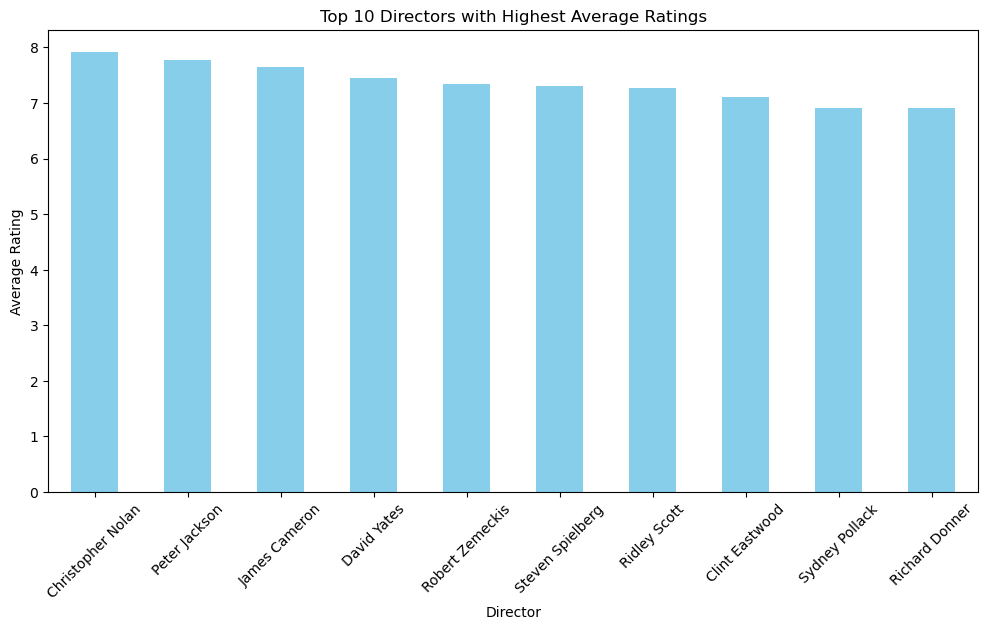

In [66]:
import matplotlib.pyplot as plt

# Counting the number of films directed by each director
director_film_counts = df['Director'].value_counts()

# Filtering directors who have directed 7 or more films
directors_with_7_or_more_films = director_film_counts[director_film_counts >= 7].index

# Filtering the original DataFrame to include only these directors
filtered_df = df[df['Director'].isin(directors_with_7_or_more_films)]

# Grouping by 'Director', calculating the mean rating, and sorting by the highest rating
top_directors = filtered_df.groupby('Director')['Rating'].mean().sort_values(ascending=False).head(10)

# Plotting the data
plt.figure(figsize=(12, 6))
top_directors.plot(kind='bar', color='skyblue')
plt.title('Top 10 Directors with Highest Average Ratings')
plt.xlabel('Director')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

In [67]:
production_companies = df['Production Companies'].str.split('|').explode()

# Counting the number of movies produced by all companies
production_companies = production_companies.value_counts()

# The top 10 production companies
production_companies.head(10)

Paramount                                              28
Marvel Studios                                         23
Universal Pictures                                     20
Warner Bros. Pictures                                  13
DreamWorks Animation                                   11
Pixar, Walt Disney Pictures                            11
20th Century Fox                                        9
Walt Disney Productions                                 9
Walt Disney Pictures, Walt Disney Feature Animation     9
Columbia Pictures                                       9
Name: Production Companies, dtype: int64

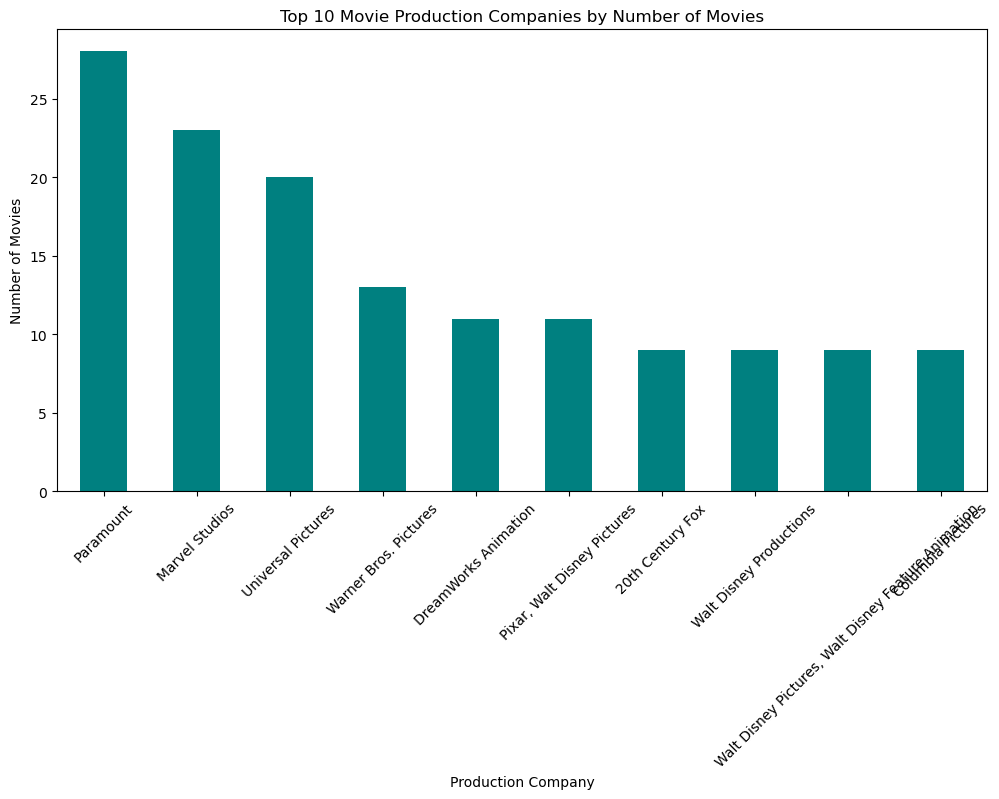

In [68]:
top_10_production_companies = production_companies.head(10)

plt.figure(figsize=(12, 6))
top_10_production_companies.plot(kind='bar', color='teal')
plt.title('Top 10 Movie Production Companies by Number of Movies')
plt.xlabel('Production Company')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

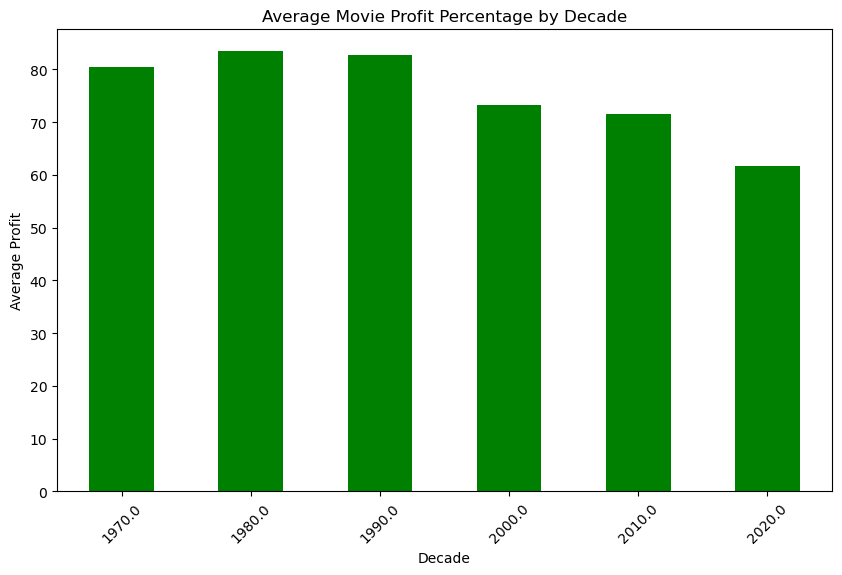

In [69]:
plt.figure(figsize=(10, 6))
average_profit_by_decade.plot(kind='bar', color='green')
plt.title('Average Movie Profit Percentage by Decade')
plt.xlabel('Decade')
plt.ylabel('Average Profit')
plt.xticks(rotation=45)
plt.show()

## Theme of these High Grossing Movies

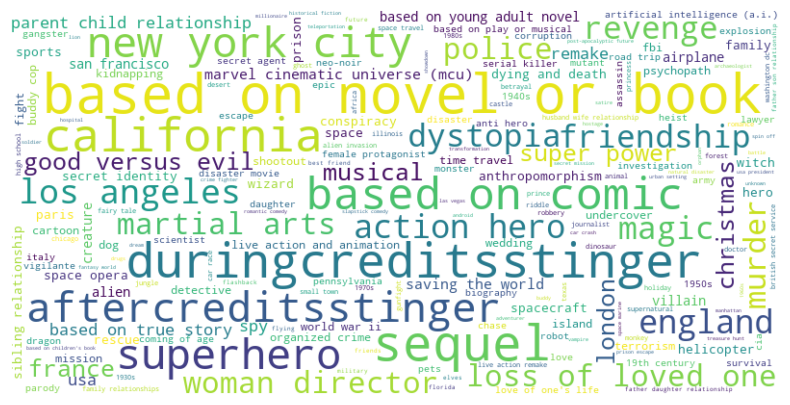

In [70]:
from wordcloud import WordCloud

keywords_series = df['Keywords'].dropna().str.split(', ').explode()

keywords_frequency = keywords_series.value_counts()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keywords_frequency)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Most of the Highest Grossing movies since the 70s were either based on an existing Intellectual Property or were sequels or had a mid credit or an after credit scene

## Theme of the High Grossing Movies of the '70s

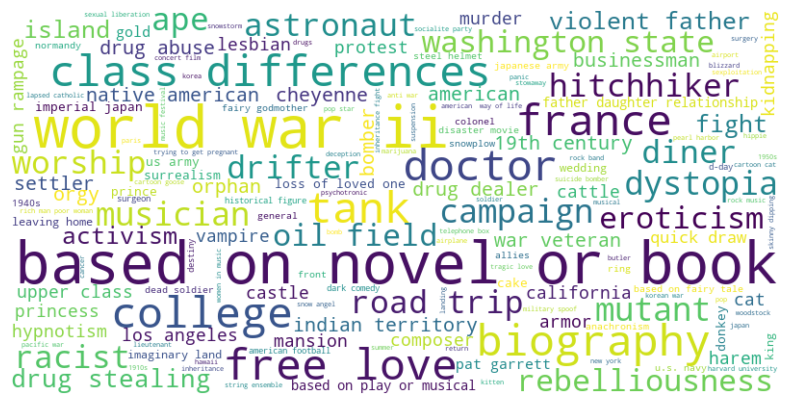

In [71]:
df_1970s = df[df['Decade'] == 1970.0]

# Splitting and exploding the 'Keywords' column for the 1970s
keywords_1970s = df_1970s['Keywords'].dropna().str.split(', ').explode()

# Generating a frequency distribution of keywords for the 1970s
keywords_frequency_1970s = keywords_1970s.value_counts()

# Creating a word cloud
wordcloud_1970s = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keywords_frequency_1970s)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1970s, interpolation='bilinear')
plt.axis('off')
plt.show()

Most of the directors during the 70s were baby boomers whose parents fought in the Second World War, so they made movies about that. Also the Baby Boomers were also hippies so they made movies about prejudices that they were fighting during the 60s. We can see it with terms like "rebelliosness", "free love", and "activism".

## Theme of the High Grossing Movies of the '80s

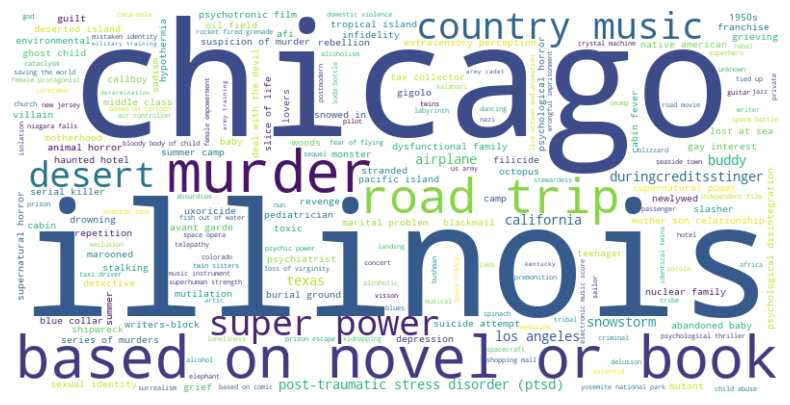

In [72]:
df_1980s = df[df['Decade'] == 1980.0]

# Splitting and exploding the 'Keywords' column for the 1970s
keywords_1980s = df_1980s['Keywords'].dropna().str.split(', ').explode()

# Generating a frequency distribution of keywords for the 1970s
keywords_frequency_1980s = keywords_1980s.value_counts()

# Creating a word cloud
wordcloud_1980s = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keywords_frequency_1980s)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1980s, interpolation='bilinear')
plt.axis('off')
plt.show()

Chicago, Illinois was the most popular theme in the highest grossing movies at the time because a lot of the coming-of-age movies that came out were directed by John Hughes who dominated the film scene in the 80s and most of his movies like The Breakfast Club and Ferris Bueller's Day Off were set in the Chicago area.

## Theme of the High Grossing Movies of the '90s

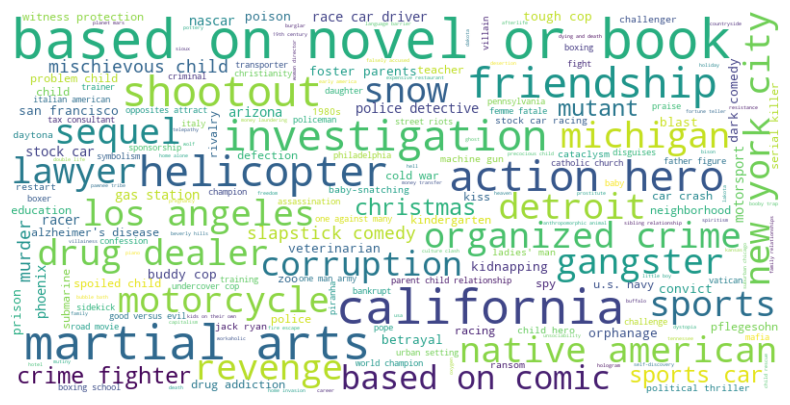

In [73]:
df_1990s = df[df['Decade'] == 1990.0]

# Splitting and exploding the 'Keywords' column for the 1970s
keywords_1990s = df_1990s['Keywords'].dropna().str.split(', ').explode()

# Generating a frequency distribution of keywords for the 1970s
keywords_frequency_1990s = keywords_1990s.value_counts()

# Creating a word cloud
wordcloud_1990s = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keywords_frequency_1990s)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1990s, interpolation='bilinear')
plt.axis('off')
plt.show()

We can see that it was the 90s where the Comic Book movies started becoming a thing. Apart from that there were also a lot of action and investigative movies being made during the time.

## Theme of the High Grossing Movies of the 2000s

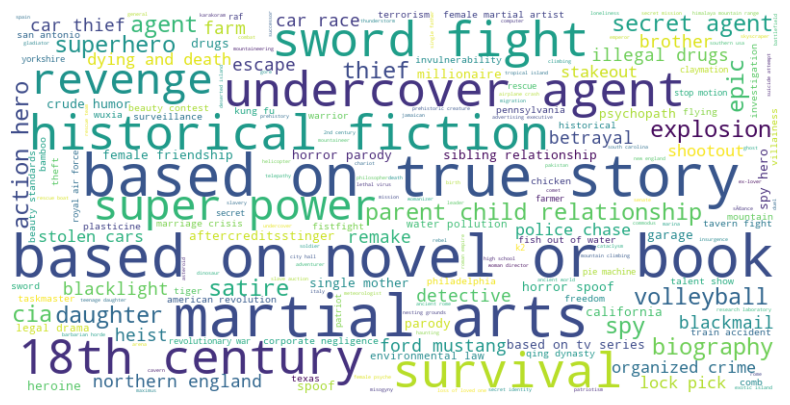

In [74]:
df_2000s = df[df['Decade'] == 2000.0]

# Splitting and exploding the 'Keywords' column for the 1970s
keywords_2000s = df_2000s['Keywords'].dropna().str.split(', ').explode()

# Generating a frequency distribution of keywords for the 1970s
keywords_frequency_2000s = keywords_2000s.value_counts()

# Creating a word cloud
wordcloud_2000s = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keywords_frequency_2000s)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_2000s, interpolation='bilinear')
plt.axis('off')
plt.show()

The trends of the 90s continued in the 200s with comic book super hero movies gradually becoming more prevalent.

## Theme of the High Grossing Movies of the 2010s

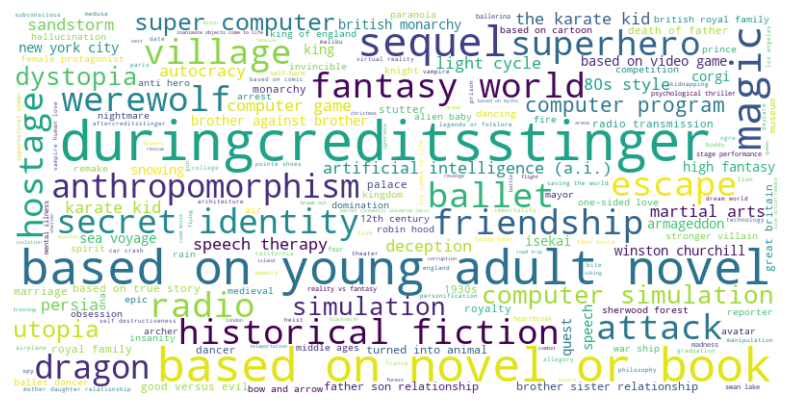

In [75]:
df_2010s = df[df['Decade'] == 2010.0]

# Splitting and exploding the 'Keywords' column for the 1970s
keywords_2010s = df_2010s['Keywords'].dropna().str.split(', ').explode()

# Generating a frequency distribution of keywords for the 1970s
keywords_frequency_2010s = keywords_2010s.value_counts()

# Creating a word cloud
wordcloud_2010s = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keywords_frequency_2010s)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_2010s, interpolation='bilinear')
plt.axis('off')
plt.show()

We can see that adaptations of Young Adult novels became more Pravelant in the 2010s with movies like the Twilight Saga, Diveergent and the Hunger Games. We can also see that Mid Credit and Post Credit Scenes also became more popular. We can also notice that a lot of science fiction themes like AI and Computer Simulation also became popular in the era along with fantasy.

## Theme of the High Grossing Movies of the 2020s

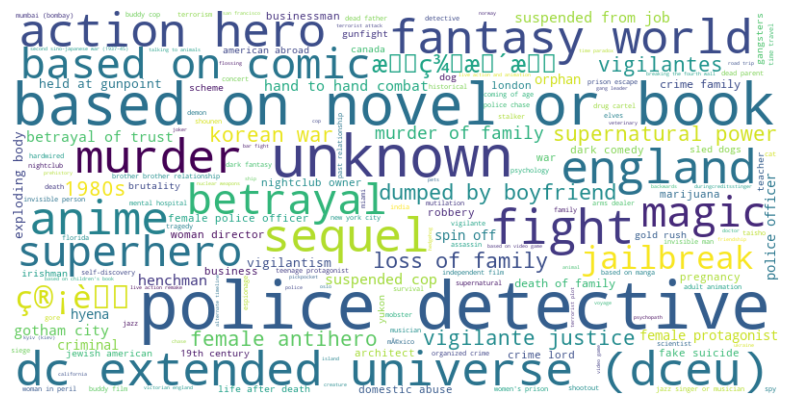

In [76]:
df_2020s = df[df['Decade'] == 2020.0]

# Splitting and exploding the 'Keywords' column for the 1970s
keywords_2020s = df_2020s['Keywords'].dropna().str.split(', ').explode()

# Generating a frequency distribution of keywords for the 1970s
keywords_frequency_2020s = keywords_2020s.value_counts()

# Creating a word cloud
wordcloud_2020s = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keywords_frequency_2020s)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_2020s, interpolation='bilinear')
plt.axis('off')
plt.show()

While we hardly are halfway done with the 2020s, we can see that this is the era where superhero movies became the most popular (as of late 2023). We can also see that animes started becoming popular in this decade too.

One theme which was common throughout this era was that the most popular movies were mostly an adaptation of an existing Intellecutal Property. They were either based on a book, a true event or a comic book.